In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from src.hdmm import workload, fairtemplates, error, fairmechanism, matrix, mechanism, templates

In [2]:
def pmw(workload, x, eps=0.01, beta=0.1, k=0, show_messages=True, to_return='pd', ):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries. New arguments to allow for optimizing the amount of
    privacy budget used in each step.
    
    to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query (query, d_t_hat, updated, algo_ans, real_ans, abs_error, 
        rel_error). 
        - if 'update_count', pmw() returns the update count for the total
        amount of queries

    - W = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    if k==0: # essentially, if k hasn't been changed from its default value, use the length of the workload
        k = len(workload)  # num of queries
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    eta = (math.log(m, np.e) ** (1 / 4)) / (math.sqrt(n))
    sigma = 10 * math.log(1 / delta, np.e) * ((math.log(m, np.e)) ** (1 / 4)) / (
            math.sqrt(n) * eps)
    threshold = 4 * sigma * (math.log(k, np.e) + math.log(1 / beta, np.e))
    
    # synthetic databases at time 0 (prior to any queries)
    y_t = np.ones(m) / m
    x_t = np.ones(m) / m

    # append to list of databases y_t and x_t
    x_list = [x_t]
    
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = []
    d_t_hat_list = []
    
    failure_mode = False # if reaches failure, failure mode because true and only runs lazy rounds
    
    def lazy_round():
        update_list.append('no')
        pmw_answers.append(np.dot(query, x_list[time]))
        x_list.append(x_list[time])
        
    
    # iterate through time = (0, k)
    for time, query in enumerate(workload):
        # compute noisy answer by adding Laplacian noise
        a_t = np.random.laplace(loc=0, scale=sigma, size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + a_t

        # difference between noisy and maintained histogram answer
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        d_t_hat_list.append(d_t_hat)

        # lazy round: use maintained histogram to answer the query
        if abs(d_t_hat) <= threshold or failure_mode:
            lazy_round()
            continue

        # update round: update histogram and return noisy answer
        else:
            update_times.append(time)

            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i, v in enumerate(y_t):
                y_t[i] = x_list[time][i] * math.exp(-eta * r_t[i])
            
            print(d_t_hat)
            print(r_t)
            print(x_list[time])
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            if update_count > n * math.log(m, np.e) ** (1 / 2): # threshold for num updates is reached, enter failure_mode
                failure_mode = True
                print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
            else: # threshold for num updates is not reached yet
                x_list.append(x_t)
                update_list.append('yes') # increment number of updates counter
                pmw_answers.append(a_t_hat / np.sum(x))
                
    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    
    def print_outputs():
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Updated Database = {x_t}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{threshold=}\n')
        print(f'Error Scale = {sigma}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
    
    def plot_error():
        """Plot absolute and relative error"""
        plt.xticks(range(0, k, 5))
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[rel_line, abs_line])
    
    if show_messages:
        print_outputs()
        plot_error()
        
    if to_return == "update_count":
        return update_count

    if to_return == "pd":
        x_list.pop(0).tolist() # remove the first synthetic database to keep length of lists consistent-x_list[t] represents the synthetic database at the end of time t
        d = {
            'queries': workload.tolist(), 
            'd_t_hat': d_t_hat_list, 
            'updated': update_list,
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'abs_error': abs_error,               
            'rel_error': rel_error,
            'synthetic database': x_list
             }
        test_data = pd.DataFrame(data=d)
        return test_data

## Failure Scenario:

Alice and Bob are analysts who query from a database, x_small, that uses private multiplicative weights in an online setting. Alice submits a set of 500 queries that only queries the first half of the database (indexes 0, 1, 2, 3). Alice's queries come first and use all the budget. Practically, that means Alice runs queries until output = failure. Then Bob does queries on index 5-7 on the synthetic database. 

Parameters: 
- x_small: [10, 80, 13, 12, 90, 14, 17, 17]
- Number of Alice's queries: 450, they only query from the **first four** slots in x_small
- Number of Bob's queries: 450, they only query from the **last four** slots in x_small


In [3]:
x_small = np.array([100, 800, 130, 120, 900, 140, 170, 170])
normalized = x_small / x_small.sum()
print(normalized)
m = x_small.size  # database len
n = x_small.sum()
print(f'the threshold for failure is {n * math.log(m, np.e) ** (1 / 2)}')

[0.03952569 0.31620553 0.0513834  0.04743083 0.35573123 0.05533597
 0.06719368 0.06719368]
the threshold for failure is 3648.328023100234


-117.85352853249924
[1. 1. 1. 1. 0. 0. 0. 0.]
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
109.57977510359126
[1. 0. 0. 0. 1. 1. 1. 1.]
[0.12350794 0.12350794 0.12350794 0.12350794 0.12649206 0.12649206
 0.12649206 0.12649206]
76.81575000529415
[0. 0. 1. 0. 1. 1. 1. 1.]
[0.12241207 0.1253697  0.1253697  0.1253697  0.1253697  0.1253697
 0.1253697  0.1253697 ]
478.06964796213424
[1. 0. 1. 1. 1. 1. 1. 1.]
[0.12424949 0.12725153 0.12424949 0.12725153 0.12424949 0.12424949
 0.12424949 0.12424949]
-201.00134397856527
[0. 0. 0. 1. 0. 0. 0. 0.]
[0.12386865 0.12992662 0.12386865 0.12686148 0.12386865 0.12386865
 0.12386865 0.12386865]
-399.65801214861756
[1. 0. 1. 0. 0. 0. 0. 0.]
[0.12424048 0.13031664 0.12424048 0.12424048 0.12424048 0.12424048
 0.12424048 0.12424048]
82.46582975270508
[0. 0. 0. 1. 1. 1. 1. 1.]
[0.12202479 0.13108506 0.12202479 0.12497307 0.12497307 0.12497307
 0.12497307 0.12497307]
57.64358295914383
[0. 0. 1. 0. 1. 1. 1. 1.]
[0.12385052 0.13304635 0.12385052 0.12385052 

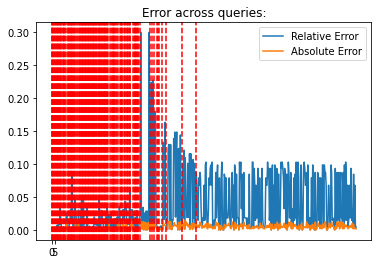

In [4]:
random_array = np.random.randint(2, size=(500,4))
zero_array = np.zeros((500,4))
alice = np.hstack((random_array, zero_array))
bob = np.hstack((zero_array, random_array))
pd.set_option("display.max_rows", None, "display.max_columns", None)
output = pmw(workload=alice, x=x_small, eps=1, beta=0.2, k=10, to_return='pd')
#print(output)

Failure Task: 
- Use a smaller database so the threshold is less
- Output when failure happened, 
- no longer update from that point and just use synthetic database (only do lazy rounds)
- in order to make it only do lazy rounds, create variable that goes into failure_mode
- fix synthetic database so that it actually updates
- [DO] PMW with just Alice and just bob - Split k and epsilon in half
- [DO] Calculate error difference. 
- [DO] Create a parallel list of people - output the labelled person, i.e. "alice" into a list. output this as a column as well

In [5]:
#testing a single update step of PMW as written

eta = 0.07549643047345178
#r_t = [1, 1, 0, 1, 1, 1, 1, 1]
r_t = [0, 0, 1, 0, 0, 0, 0, 0]
x_t = [0.00000488, 0.00000008, 0.99999135, 0.00000361, 0.00000002, 0.00000002,
 0.00000002, 0.00000002]
y_t = np.ones(8) / 8
for i, v in enumerate(y_t):
    y_t[i] = x_t[i] * math.exp(-eta * r_t[i])
    print(math.exp(-eta * r_t[i]))
    
print(y_t)
print(y_t / np.sum(y_t))


1.0
1.0
0.927283040489522
1.0
1.0
1.0
1.0
1.0
[0.00000488 0.00000008 0.92727502 0.00000361 0.00000002 0.00000002
 0.00000002 0.00000002]
[0.00000526 0.00000009 0.99999067 0.00000389 0.00000002 0.00000002
 0.00000002 0.00000002]


# Variant PMW based off MWEM using the sparce vector technique

This method should be equivalent but have significantly less tuning knobs

In [6]:
def SVT(x, q, T, epsilon):
    epsilon1 = epsilon/2
    epsilon2 = epsilon/2
    

In [20]:
def pmw2(workload, x, T, eps=0.01, k=0, show_messages=True, to_return='pd', ):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries. New arguments to allow for optimizing the amount of
    privacy budget used in each step.
    
    to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query (query, d_t_hat, updated, algo_ans, real_ans, abs_error, 
        rel_error). 
        - if 'update_count', pmw() returns the update count for the total
        amount of queries

    - W = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    - eps = privacy budget
    - k = number of update steps
    - T  = update threshold
    """ 
    
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    eta = (math.log(m, np.e) ** (1 / 4)) / (math.sqrt(n))
    # Set k to be the desired number of update rounds
    if k==0: # essentially, if k hasn't been changed from its default value, use the length of the workload
        k = len(workload)  # num of queries
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    # synthetic databases at time 0 (prior to any queries)
    y_t = np.ones(m) / m
    x_t = np.ones(m) / m

    # append to list of databases y_t and x_t
    x_list = [x_t]
    
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = []
    d_t_hat_list = []
    
    failure_mode = False # if reaches failure, failure mode because true and only runs lazy rounds
    
    def lazy_round():
        update_list.append('no')
        pmw_answers.append(np.dot(query, x_list[time]))
        x_list.append(x_list[time])
        
    
    #inititate first instance of SVT with half the budget and k updates
    #will be reset in the main loop
    SVTtrigger = False 
    SVTepsilon1 =((eps/2)/2)
    SVTepsilon2 = ((eps/2)/2)
    rho = np.random.laplace(loc=0, scale=(1/SVTepsilon1), size=1)[0]
    # iterate through time 
    for time, query in enumerate(workload):
        # Do one round of sparce vector technique 
        
        # compute noisy answer by adding Laplacian noise
        a_t = np.random.laplace(loc=0, scale=(2*k/SVTepsilon2), size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + a_t

        # difference between noisy and maintained histogram answer
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        

        # lazy round: use maintained histogram to answer the query
        if (abs(d_t_hat) <= T + rho) or failure_mode:
            d_t_hat_list.append(d_t_hat)
            lazy_round()
            continue

        # update round: update histogram and return noisy answer
        else:
            update_times.append(time)
            #make a new noisy query answer using some of the leftover budget
            a_t = np.random.laplace(loc=0, scale=(2*k/eps), size=1)[0]
            a_t_hat = (np.dot(query, x_norm)*n ) + a_t
            d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
            d_t_hat_list.append(d_t_hat)
            
            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i, v in enumerate(y_t):
                #y_t[i] = x_list[time][i] * math.exp(-eta * r_t[i])
                y_t[i] = x_list[time][i] * math.exp((d_t_hat/(2*n)) * query[i])
            
            print(d_t_hat)
            print(query)
            print(x_list[time])
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            if update_count >= k: # threshold for num updates is reached, enter failure_mode
                failure_mode = True
                print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
            else: # threshold for num updates is not reached yet
                x_list.append(x_t)
                update_list.append('yes') # increment number of updates counter
                pmw_answers.append(a_t_hat / np.sum(x))
                
    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    
    def print_outputs():
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Updated Database = {x_t}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{T=}\n')
        print(f'Error Scale Query Answer= {2*((2*k/eps)**2)}\n')
        print(f'Error Scale SVT= {2*((2*k/SVTepsilon2)**2)}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
    
    def plot_error():
        """Plot absolute and relative error"""
        plt.xticks(range(0, k, 5))
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[rel_line, abs_line])
    
    if show_messages:
        print_outputs()
        plot_error()
        
    if to_return == "update_count":
        return update_count

    if to_return == "pd":
        x_list.pop(0).tolist() # remove the first synthetic database to keep length of lists consistent-x_list[t] represents the synthetic database at the end of time t
        d = {
            'queries': workload.tolist(), 
            'd_t_hat': d_t_hat_list, 
            'updated': update_list,
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'abs_error': abs_error,               
            'rel_error': rel_error,
            'synthetic database': x_list
             }
        test_data = pd.DataFrame(data=d)
        return test_data

239.32648714837853
[0. 1. 1. 0. 0. 0. 0. 0.]
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
-445.63169761034806
[0. 0. 1. 1. 0. 0. 0. 0.]
[0.12350454 0.12948637 0.12948637 0.12350454 0.12350454 0.12350454
 0.12350454 0.12350454]
-580.3016862462343
[1. 0. 1. 1. 0. 0. 0. 0.]
[0.12619603 0.13230822 0.12115427 0.11555736 0.12619603 0.12619603
 0.12619603 0.12619603]
-40.715068729814675
[1. 1. 1. 1. 0. 0. 0. 0.]
[0.1171281  0.13772378 0.11244862 0.10725388 0.13136141 0.13136141
 0.13136141 0.13136141]
-40.31786928985555
[0. 0. 0. 0. 0. 0. 0. 0.]
[0.11663299 0.13714161 0.11197329 0.10680051 0.1318629  0.1318629
 0.1318629  0.1318629 ]
-94.13140306641662
[1. 1. 1. 1. 0. 0. 0. 0.]
[0.11663299 0.13714161 0.11197329 0.10680051 0.1318629  0.1318629
 0.1318629  0.1318629 ]
349.2951420895374
[0. 1. 1. 0. 0. 0. 0. 0.]
[0.11548918 0.13579667 0.11087518 0.10575312 0.13302146 0.13302146
 0.13302146 0.13302146]
-170.09434270177852
[1. 0. 0. 0. 0. 0. 0. 0.]
[0.11348845 0.14298126 0.11674125 0.10392106

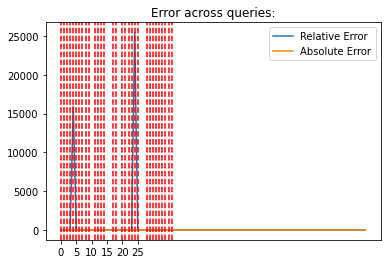

In [21]:
random_array = np.random.randint(2, size=(100,4))
zero_array = np.zeros((100,4))
alice = np.hstack((random_array, zero_array))
bob = np.hstack((zero_array, random_array))
pd.set_option("display.max_rows", None, "display.max_columns", None)
output = pmw2(workload=alice, x=x_small, eps=1, T= 100, k=30, to_return='pd')
#print(output)